In [31]:
# Standard library
import sys
import os

# Core scientific packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import tqdm

# Image processing
from skimage import img_as_float
from skimage.transform import resize
from scipy.signal import convolve2d
from PIL import Image

# Wavelet transforms
!pip install PyWavelets scikit-image > /dev/null 2>&1
import pywt

In [ ]:
# --- Utility Functions --- #

def gaussian_kernel(size=9, sigma=4):
    ax = np.linspace(-(size // 2), size // 2, size)  # Create linearly spaced values
    xx, yy = np.meshgrid(ax, ax)  # Create mesh grid for 2D convolution
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))  # Gaussian function
    return kernel / np.sum(kernel)  # Normalize kernel to ensure sum is 1

def soft_thresholding(x, lmbda):
    return np.sign(x) * np.maximum(np.abs(x) - lmbda, 0)  # Soft thresholding rule

def soft_thresholding_newt(x, H, lmbda):
    return np.sign(x) * np.maximum(np.abs(x) - lmbda/H, 0)  # Soft thresholding with scaling factor

def wavelet_transform(x, wavelet='db1', level=4):
    coeffs = pywt.wavedec2(x, wavelet=wavelet, level=level)  # Decompose the input using wavelet transform
    coeffs_flat, slices = pywt.coeffs_to_array(coeffs)  # Flatten the coefficients into array form
    return coeffs_flat, slices  # Return flattened coefficients and slice structure

def inverse_wavelet_transform(coeffs_flat, slices, wavelet='db1'):
    coeffs = pywt.array_to_coeffs(coeffs_flat, slices, output_format='wavedec2')  # Convert flat array back to wavelet coefficients
    return pywt.waverec2(coeffs, wavelet=wavelet)  # Reconstruct the signal/image using inverse wavelet transform

def objective(alpha, noisy, A_func):
    residual = A_func(alpha) - noisy  # Compute residual (difference between model and noisy data)
    return 0.5 * np.sum(residual ** 2)  # Sum of squared residuals (least squares objective)

def full_objective(alpha, noisy, A_func, lambd):
    return objective(alpha, noisy, A_func) + lambd * np.linalg.norm(alpha, 1)  # Objective with L1 regularization

def gradient(alpha, noisy, A_func, At_func):
    return At_func(A_func(alpha) - noisy)  # Gradient of the data fidelity term (using adjoint operator)

# --- Define blur operators in sparse domain --- #

def A_func(alpha):
    x = inverse_wavelet_transform(alpha, slices, wavelet=wavelet)  # Reconstruct the signal/image from sparse coefficients
    return convolve2d(x, kernel, mode='same', boundary='wrap')  # Apply convolution with Gaussian kernel

def At_func(residual):
    grad_x = convolve2d(residual, kernel, mode='same', boundary='wrap')  # Apply convolution with Gaussian kernel
    grad_alpha, _ = wavelet_transform(grad_x, wavelet=wavelet, level=level)  # Transform the gradient into sparse domain
    return grad_alpha  # Return sparse domain representation of the gradient


In [ ]:
# --- ISTA Algorithm with Backtracking Line Search --- #
def ista_backtracking(y, A_func, At_func, slices, lambd=0.01, L_init=1.0, eta=2.0, max_iter=100, tol=1e-4):
    alpha = np.zeros_like(At_func(y))  # Initialize the solution as zero
    L = L_init  # Initial step size (Lipschitz constant)

    psnrs = []  # List to store PSNR values during iterations
    alphas = []  # List to store alpha values during iterations
    f_prev = full_objective(alpha, y, A_func, lambd)  # Initial objective value

    for i in tqdm.tqdm(range(max_iter), desc="Progress"):  # Iterate for max_iter times
        grad = gradient(alpha, y, A_func, At_func)  # Compute gradient of the objective function

        # Backtracking line search
        L_bt = L  # Start with the initial step size
        while True:
            alpha_temp = soft_thresholding(alpha - grad / L_bt, lambd / L_bt)  # Update alpha using soft thresholding
            diff = alpha_temp - alpha  # Difference between current and updated alpha
            lhs = objective(alpha_temp, y, A_func)  # Left-hand side of the inequality
            rhs = objective(alpha, y, A_func) + np.dot(grad.flatten(), diff.flatten()) + \
                  (L_bt / 2) * np.linalg.norm(diff) ** 2  # Right-hand side of the inequality
            if lhs <= rhs:  # If inequality holds, break the loop
                break
            L_bt *= eta  # Otherwise, decrease L by the factor eta

        alpha = alpha_temp  # Update alpha with the new value
        L = L_bt  # Update L with the new value from backtracking

        # Compute the current objective value and check for convergence
        f_curr = full_objective(alpha, y, A_func, lambd)
        if abs(f_curr - f_prev) < tol:  # If the change in the objective is below the tolerance, stop
            alphas.append(alpha)
            restored = inverse_wavelet_transform(alpha, slices, wavelet='db1')  # Reconstruct the signal
            psnr = 10 * np.log10(1 / np.mean((original - restored) ** 2))  # Compute PSNR
            psnrs.append(psnr)  # Append PSNR to the list
            break
        f_prev = f_curr  # Update the previous objective value

        # PSNR tracking for each iteration
        alphas.append(alpha)
        restored = inverse_wavelet_transform(alpha, slices, wavelet='db1')  # Reconstruct the signal
        psnr = 10 * np.log10(1 / np.mean((original - restored) ** 2))  # Compute PSNR
        psnrs.append(psnr)  # Append PSNR to the list

    return alpha, psnrs, alphas  # Return the final result and PSNRs over iterations

# --- FISTA Algorithm with Backtracking Line Search --- #
def fista_backtracking(y, A_func, At_func, slices, lambd=0.01, L_init=1.0, eta=2.0, max_iter=100, tol=1e-4):
    alpha = np.zeros_like(At_func(y))  # Initialize alpha (solution) as zero
    z = np.copy(alpha)  # Initialize z (auxiliary variable) as a copy of alpha
    t = 1  # Initial value for the t parameter
    L = L_init  # Initial step size (Lipschitz constant)

    psnrs = []  # List to store PSNR values during iterations
    alphas = []  # List to store alpha values during iterations
    f_prev = full_objective(alpha, y, A_func, lambd)  # Initial objective value

    for i in tqdm.tqdm(range(max_iter), desc="Progress"):  # Iterate for max_iter times
        grad = gradient(alpha, y, A_func, At_func)  # Compute gradient of the objective function

        # Backtracking line search
        L_bt = L  # Start with the initial step size
        while True:
            alpha_temp = soft_thresholding(z - grad / L_bt, lambd / L_bt)  # Update alpha using soft thresholding
            diff = alpha_temp - z  # Difference between current and updated z
            lhs = objective(alpha_temp, y, A_func)  # Left-hand side of the inequality
            rhs = objective(z, y, A_func) + np.dot(grad.flatten(), diff.flatten()) + \
                  (L_bt / 2) * np.linalg.norm(diff)**2  # Right-hand side of the inequality
            if lhs <= rhs:  # If inequality holds, break the loop
                break
            L_bt *= eta  # Otherwise, decrease L by the factor eta

        alpha_new = alpha_temp  # Update alpha with the new value from backtracking
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2  # Update t using FISTA formula
        z = alpha_new + ((t - 1) / t_new) * (alpha_new - alpha)  # Update z using FISTA update rule
        alpha, t, L = alpha_new, t_new, L_bt  # Update alpha, t, and L

        # Compute the current objective value and check for convergence
        f_curr = full_objective(alpha, y, A_func, lambd)
        if abs(f_curr - f_prev) < tol:  # If the change in the objective is below the tolerance, stop
            alphas.append(alpha)
            restored = inverse_wavelet_transform(alpha, slices, wavelet='db1')  # Reconstruct the signal
            psnr = 10 * np.log10(1 / np.mean((original - restored) ** 2))  # Compute PSNR
            psnrs.append(psnr)  # Append PSNR to the list
            break
        f_prev = f_curr  # Update the previous objective value

        # PSNR tracking for each iteration
        alphas.append(alpha)
        restored = inverse_wavelet_transform(alpha, slices, wavelet='db1')  # Reconstruct the signal
        psnr = 10 * np.log10(1 / np.mean((original - restored) ** 2))  # Compute PSNR
        psnrs.append(psnr)  # Append PSNR to the list

    return alpha, psnrs, alphas  # Return the final result and PSNRs over iterations

In [ ]:
# --- L-BFGS Two-Loop Recursion --- #
class LBFGS:
    def __init__(self, m=10):
        self.m = m  # Maximum number of corrections to store
        self.s_list = []  # List to store s vectors
        self.y_list = []  # List to store y vectors
        self.rho_list = []  # List to store rho values

    def update(self, s, y):
        ys = np.dot(y, s)  # Compute the dot product of y and s
        if ys <= 1e-10:  # Avoid division by very small numbers
            return

        # If the lists are full, remove the oldest elements
        if len(self.s_list) == self.m:
            self.s_list.pop(0)
            self.y_list.pop(0)
            self.rho_list.pop(0)

        # Add new s, y, and rho values to the lists
        self.s_list.append(s)
        self.y_list.append(y)
        self.rho_list.append(1.0 / ys)  # Store the inverse of ys

    def two_loop(self, grad):
        q = grad.copy()  # Initialize q as a copy of the gradient
        alpha_list = []  # List to store alpha values for the two-loop recursion

        # First loop: compute alpha values
        for s, y, rho in reversed(list(zip(self.s_list, self.y_list, self.rho_list))):
            alpha = rho * np.dot(s, q)  # Compute alpha
            q -= alpha * y  # Update q by subtracting the contribution of s and y
            alpha_list.append(alpha)  # Store the alpha value

        # Compute H0 (approximation to the inverse Hessian)
        if self.y_list:
            y, s = self.y_list[-1], self.s_list[-1]
            H0 = np.dot(y, s) / (np.dot(y, y) + 1e-10)  # Use a small regularization term
        else:
            H0 = 1.0  # If there are no stored corrections, use the identity matrix

        r = H0 * q  # Scale q by H0 to initialize r

        # Second loop: update r using the stored s and y vectors
        for s, y, rho, alpha in zip(self.s_list, self.y_list, self.rho_list, reversed(alpha_list)):
            beta = rho * np.dot(y, r)  # Compute the coefficient beta
            r += s * (alpha - beta)  # Update r

        return r  # Return the computed direction (H @ grad)

    def get_H_approx(self):
        # Get an approximation of the inverse Hessian (H0)
        if self.y_list:
            y, s = self.y_list[-1], self.s_list[-1]
            H0 = np.dot(y, s) / (np.dot(y, y) + 1e-10)  # Approximate H0 using the last s and y
            return H0
        else:
            return 1.0  # If there are no corrections, return the identity matrix

# --- Proximal Newton Method with L-BFGS Updates --- #
def proximal_newton(y, A_func, At_func, slices, exact=False, lambd=2e-5, max_iter=20, tol=1e-4):
    alpha = np.zeros_like(At_func(y))  # Initialize alpha (the sparse representation) as zero
    shape = alpha.shape  # Store the shape of alpha for reshaping later
    alpha = alpha.flatten()  # Flatten alpha for optimization
    lbfgs = LBFGS(m=20)  # Create an instance of the LBFGS optimizer

    yn = y.copy()  # Make a copy of the noisy data

    psnrs = []  # List to store PSNR values during iterations
    alphas = []  # List to store alpha values during iterations

    f_prev = objective(alpha.reshape(shape), yn, A_func)  # Compute the initial objective value

    for k in tqdm.tqdm(range(max_iter), desc="Progress"):  # Iterate for max_iter times
        grad = gradient(alpha.reshape(shape), yn, A_func, At_func).flatten()  # Compute gradient of the objective function

        p = lbfgs.two_loop(grad)  # Get the descent direction using L-BFGS
        x_tilde = alpha - p  # Compute the updated alpha using the L-BFGS direction

        # Proximal step (soft thresholding with Newton update)
        z = soft_thresholding_newt(x_tilde, lbfgs.get_H_approx(), lambd)

        # Line search to determine the step size
        dx = z - alpha  # Compute the difference between the updated and current alpha
        t = 1.0  # Initial step size
        beta = 0.7  # Factor to reduce the step size
        # Perform line search to ensure sufficient decrease in the objective
        while full_objective((alpha + t * dx).reshape(shape), yn, A_func, lambd) > \
              full_objective(alpha.reshape(shape), yn, A_func, lambd) + 1e-4 * t * (grad @ dx):
              t *= beta  # Reduce the step size by the factor beta

        alpha_next = alpha + t * dx  # Update alpha with the computed step size

        # Update L-BFGS with the new s and y vectors
        s = alpha_next - alpha  # Compute the change in alpha
        y = gradient(alpha_next.reshape(shape), yn, A_func, At_func).flatten() - grad  # Compute the change in gradient
        lbfgs.update(s, y)  # Update the L-BFGS memory with s and y

        alpha = alpha_next  # Update alpha

        # Compute current objective value and check for stopping criterion
        f_curr = objective(alpha.reshape(shape), yn, A_func)
        if abs(f_curr - f_prev) < tol:  # If the change in objective is smaller than tolerance, stop
            alphas.append(alpha.reshape(shape))  # Save the result
            restored = inverse_wavelet_transform(alpha.reshape(shape), slices, wavelet=wavelet)  # Reconstruct the signal
            psnr = 10 * np.log10(1 / np.mean((original - restored) ** 2))  # Compute PSNR
            psnrs.append(psnr)  # Append PSNR to the list
            break

        f_prev = f_curr  # Update the previous objective value

        # Track results (PSNR and alpha)
        alphas.append(alpha.reshape(shape))
        restored = inverse_wavelet_transform(alpha.reshape(shape), slices, wavelet=wavelet)  # Reconstruct the signal
        psnr = 10 * np.log10(1 / np.mean((original - restored) ** 2))  # Compute PSNR
        psnrs.append(psnr)  # Append PSNR to the list

    return alpha.reshape(shape), psnrs, alphas  # Return the final alpha, PSNRs, and alpha history


In [ ]:
# --- Load and degrade image --- #
img = Image.open('camera.png')  # Load the original image from file
original = img_as_float(img)  # Convert the image to a floating-point format in range [0, 1]

# Blur the image using a Gaussian kernel
kernel = gaussian_kernel(size=9, sigma=4)  # Generate a Gaussian kernel with size 9 and sigma 4
blurred = convolve2d(original, kernel, mode='same', boundary='wrap')  # Apply the kernel to blur the image

# No noise added, so the noisy image is just the blurred one
noisy = blurred.copy()  # Since no noise is added, set noisy equal to blurred

# --- Define wavelet transforms ---
wavelet = 'db1'  # Choose the 'db1' wavelet (Daubechies wavelet with 1 vanishing moment)
level = 3  # Set the wavelet decomposition level to 3

# Compute wavelet coefficients of the original image (this is optional for comparison)
alpha_opt, _ = wavelet_transform(original, wavelet=wavelet, level=level)

# Compute wavelet coefficients of the blurred (noisy) image
alpha0, slices = wavelet_transform(noisy, wavelet=wavelet, level=level)

# Regularization parameter for the optimization problem (used in ISTA, FISTA, and Proximal Newton)
lambda_reg = 2e-5  # Regularization parameter (small value)
max_iter = 500  # Set the maximum number of iterations
tol = -np.inf  # Tolerance for stopping criterion (use negative infinity to disable stopping based on tolerance)

# --- Run ISTA (Iterative Shrinkage Thresholding Algorithm) --- #
alpha_est_ista, psnrs_ista, all_alphas_ista = ista_backtracking(
    noisy, A_func, At_func, slices, lambd=lambda_reg, L_init=1,  # Run ISTA with initial step size L_init=1
    eta=2.0, max_iter=max_iter, tol=tol  # Set parameters for ISTA backtracking
)
restored_ista = inverse_wavelet_transform(alpha_est_ista, slices, wavelet=wavelet)  # Reconstruct the image using inverse wavelet transform

# --- Run FISTA (Fast Iterative Shrinkage Thresholding Algorithm) --- #
alpha_est_fista, psnrs_fista, all_alphas_fista = fista_backtracking(
    noisy, A_func, At_func, slices, lambd=lambda_reg, L_init=1,  # Run FISTA with the same parameters as ISTA
    eta=2.0, max_iter=max_iter, tol=tol  # Set parameters for FISTA backtracking
)
restored_fista = inverse_wavelet_transform(alpha_est_fista, slices, wavelet=wavelet)  # Reconstruct the image using inverse wavelet transform

# --- Run Proximal Newton Method --- #
alpha_est_quasi_newt, psnrs_quasi_newt, all_alphas_quasi_newt = proximal_newton(
    noisy, A_func, At_func, slices, lambd=lambda_reg, max_iter=max_iter, tol=tol  # Run Proximal Newton method
)
restored_quasi_newt = inverse_wavelet_transform(alpha_est_quasi_newt, slices, wavelet=wavelet)  # Reconstruct the image using inverse wavelet transform

Progress: 100%|██████████| 500/500 [02:15<00:00,  3.69it/s]


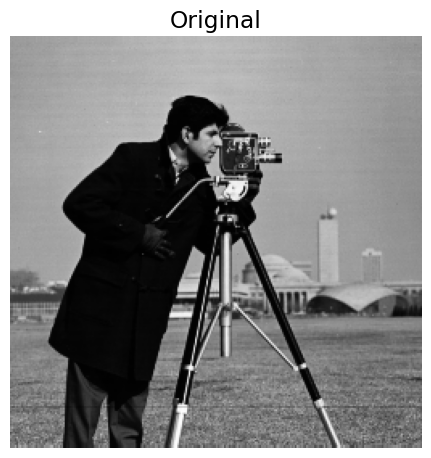

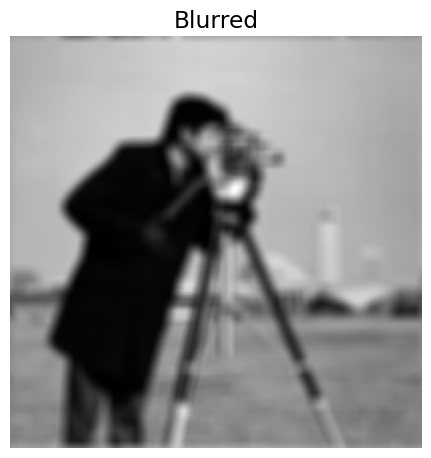

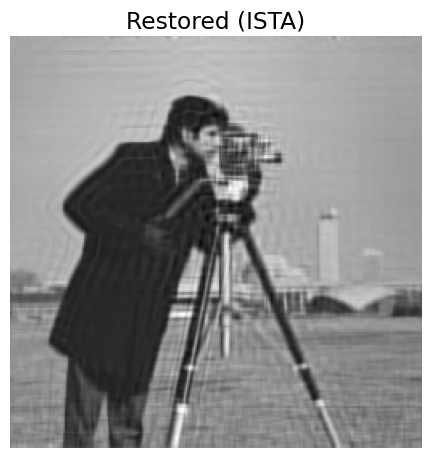

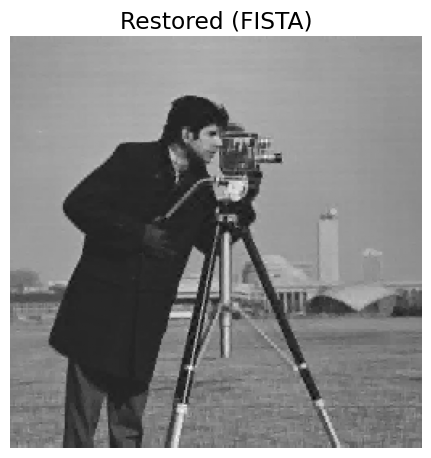

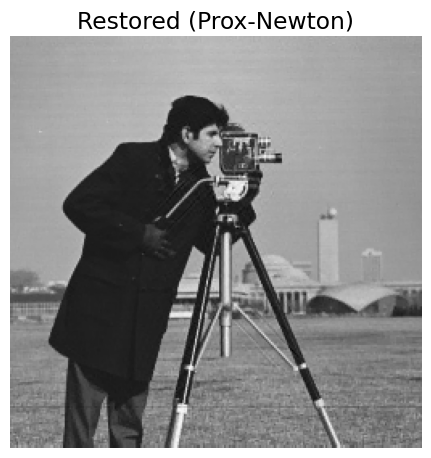

In [35]:
# Compute the wavelet coefficients of the original image (used as ground truth for comparison)
alpha_opt, _ = wavelet_transform(original, wavelet=wavelet, level=level)

# Calculate the objective value for the ground truth (original) image
opt_val = objective(alpha_opt, noisy, A_func)

# Compute the objective values for all the intermediate solutions obtained during ISTA, FISTA, and Proximal Newton
# These are used for tracking the convergence of each method
obj_vals_ista = [objective(a, noisy, A_func) for a in all_alphas_ista]
obj_vals_fista = [objective(a, noisy, A_func) for a in all_alphas_fista]
obj_vals_quasi_newt = [objective(a, noisy, A_func) for a in all_alphas_quasi_newt]

# Compute the difference between the objective values of each iteration and the optimal objective value
val_diff_ista = [abs(val - opt_val) for val in obj_vals_ista]
val_diff_fista = [abs(val - opt_val) for val in obj_vals_fista]
val_diff_quasi_newt = [abs(val - opt_val) for val in obj_vals_quasi_newt]

# --- Plot results --- #

# Display the original image
plt.figure
plt.title("Original")
plt.imshow(original, cmap='gray')  # Show the original image in grayscale
plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

# Display the noisy (blurred) image
plt.figure
plt.title("Blurred")
plt.imshow(noisy, cmap='gray')  # Show the noisy image in grayscale
plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

# Display the image restored by ISTA
plt.figure
plt.title("Restored (ISTA)")
plt.imshow(restored_ista, cmap='gray')  # Show the restored image using ISTA
plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

# Display the image restored by FISTA
plt.figure
plt.title("Restored (FISTA)")
plt.imshow(restored_fista, cmap='gray')  # Show the restored image using FISTA
plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

# Display the image restored by Proximal Newton
plt.figure
plt.title("Restored (Prox-Newton)")
plt.imshow(restored_quasi_newt, cmap='gray')  # Show the restored image using Proximal Newton
plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

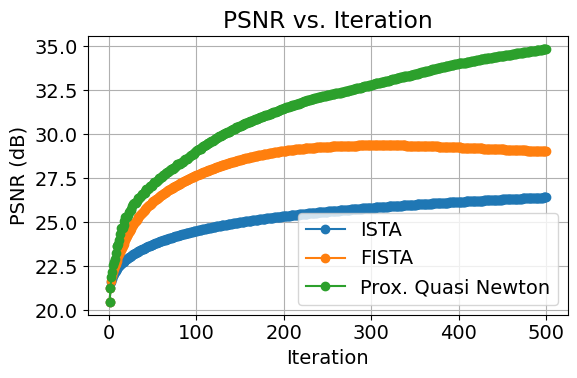

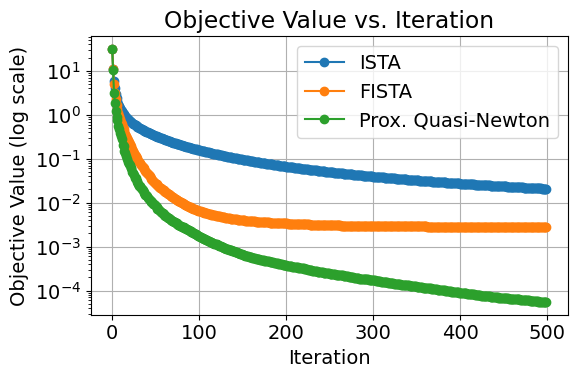

In [34]:
# -- PSNR Plot --
# Plot the PSNR (Peak Signal-to-Noise Ratio) for each method over iterations
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(psnrs_ista) + 1), psnrs_ista, marker='o', label='ISTA')  # Plot PSNR for ISTA
plt.plot(range(1, len(psnrs_fista) + 1), psnrs_fista, marker='o', label='FISTA')  # Plot PSNR for FISTA
plt.plot(range(1, len(psnrs_quasi_newt) + 1), psnrs_quasi_newt, marker='o', label='Prox. Quasi Newton')  # Plot PSNR for Proximal Newton
plt.legend()  # Show legend for the methods
plt.xlabel("Iteration")  # Label for x-axis
plt.ylabel("PSNR (dB)")  # Label for y-axis
plt.title("PSNR vs. Iteration")  # Title of the plot
plt.grid(True)  # Show grid lines for better readability
plt.tight_layout()
plt.show()

# -- Objective Value Gap Plot --
# Plot the difference between the objective values at each iteration for all methods
plt.figure(figsize=(6, 4))
plt.plot(obj_vals_ista, marker='o', label='ISTA')  # Plot objective value gap for ISTA
plt.plot(obj_vals_fista, marker='o', label='FISTA')  # Plot objective value gap for FISTA
plt.plot(obj_vals_quasi_newt, marker='o', label='Prox. Quasi-Newton')  # Plot objective value gap for Proximal Newton
plt.yscale('log')  # Set the y-axis scale to logarithmic for better visibility of changes over time
plt.xlabel('Iteration')  # Label for x-axis
plt.ylabel('Objective Value (log scale)')  # Label for y-axis
plt.title('Objective Value vs. Iteration')  # Title of the plot
plt.legend()  # Show legend for the methods
plt.grid(True)  # Show grid lines for better readability
plt.tight_layout()
plt.show()

In [ ]:
# --- Load and degrade image ---
# Load the image and convert it to floating point format
img = Image.open('camera.png')  # Open the image 'camera.png'
original = img_as_float(img)  # Convert the image to floating point format for processing

# Apply a Gaussian blur to the original image to simulate a degradation
kernel = gaussian_kernel(size=9, sigma=4)  # Create a Gaussian kernel of size 9x9 with sigma 4
blurred = convolve2d(original, kernel, mode='same', boundary='wrap')  # Apply the kernel to the original image

# Add Gaussian noise to the blurred image to further degrade it
noise_sigma = 1e-3  # Define the standard deviation of the noise
noisy2 = blurred + noise_sigma * np.random.randn(*blurred.shape)  # Add random Gaussian noise

# --- Define wavelet transforms ---
# Set parameters for wavelet transformation
wavelet = 'db1'  # Use Daubechies wavelet (db1)
level = 3  # Set the level of decomposition for the wavelet transform

# Compute the wavelet coefficients for the original image
alpha_opt, _ = wavelet_transform(original, wavelet=wavelet, level=level)

# Compute the wavelet coefficients for the noisy image
alpha0, slices = wavelet_transform(noisy2, wavelet=wavelet, level=level)

# Set regularization parameter and optimization parameters
lambda_reg = 2e-5  # Regularization parameter (controls sparsity)
max_iter = 100  # Maximum number of iterations for the optimization
tol = -np.inf  # Tolerance for convergence (no specific stopping criterion)

# --- Run ISTA ---
# Perform ISTA with backtracking line search on the noisy image
alpha_est_ista2, psnrs_ista2, all_alphas_ista2 = ista_backtracking(
    noisy2, A_func, At_func, slices, lambd=lambda_reg, L_init=1, eta=2.0, max_iter=max_iter, tol=tol
)
# Inverse wavelet transform to restore the image from the estimated coefficients
restored_ista2 = inverse_wavelet_transform(alpha_est_ista2, slices, wavelet=wavelet)

# --- Run FISTA ---
# Perform FISTA with backtracking line search on the noisy image
alpha_est_fista2, psnrs_fista2, all_alphas_fista2 = fista_backtracking(
    noisy2, A_func, At_func, slices, lambd=lambda_reg, L_init=1, eta=2.0, max_iter=max_iter, tol=tol
)
# Inverse wavelet transform to restore the image from the estimated coefficients
restored_fista2 = inverse_wavelet_transform(alpha_est_fista2, slices, wavelet=wavelet)

# --- Run Proximal Newton ---
# Perform Proximal Newton with the noisy image
alpha_est_quasi_newt2, psnrs_quasi_newt2, all_alphas_quasi_newt2 = proximal_newton(
    noisy2, A_func, At_func, slices, lambd=lambda_reg, max_iter=max_iter, tol=tol
)
# Inverse wavelet transform to restore the image from the estimated coefficients
restored_quasi_newt2 = inverse_wavelet_transform(alpha_est_quasi_newt2, slices, wavelet=wavelet)


Progress: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


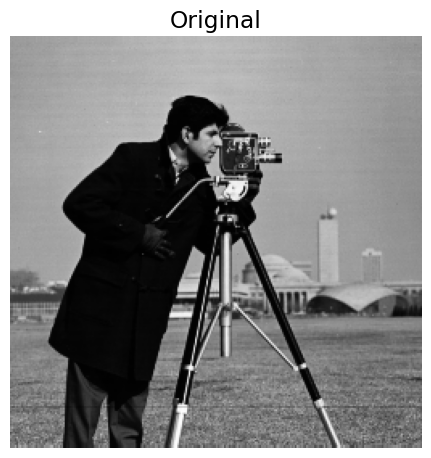

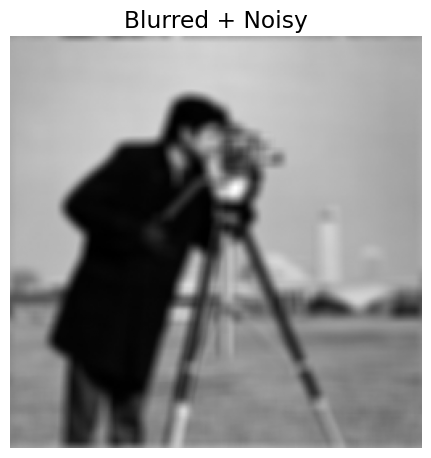

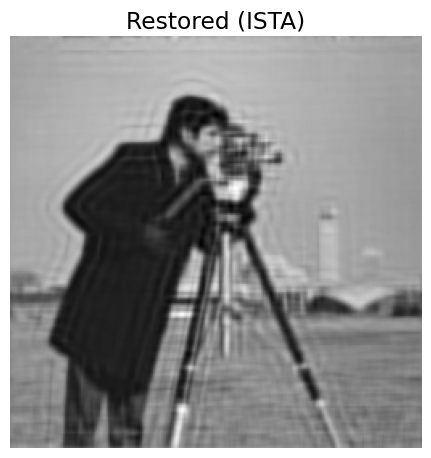

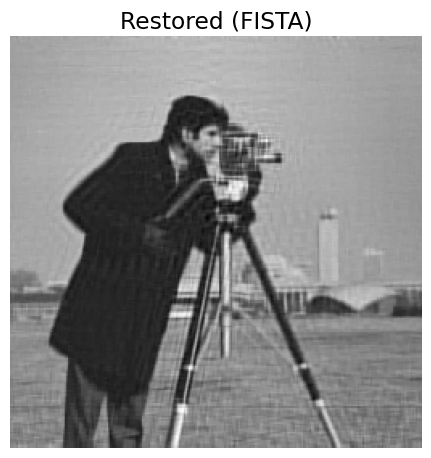

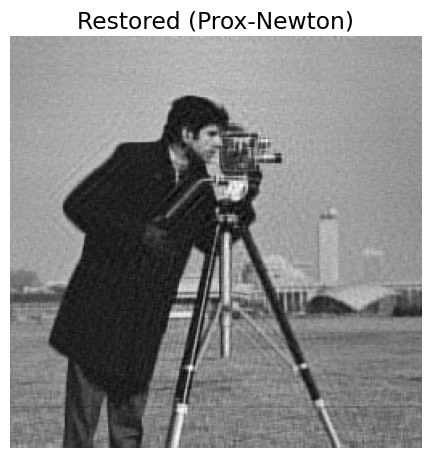

In [38]:
# Compute wavelet coefficients for the original image
alpha_opt, _ = wavelet_transform(original, wavelet=wavelet, level=level)

# Compute the objective value for the original (ideal) solution on the noisy image
opt_val = objective(alpha_opt, noisy2, A_func)

# Calculate the objective values for each optimization method at each iteration
obj_vals_ista2 = [objective(a, noisy2, A_func) for a in all_alphas_ista2]
obj_vals_fista2 = [objective(a, noisy2, A_func) for a in all_alphas_fista2]
obj_vals_quasi_newt2 = [objective(a, noisy2, A_func) for a in all_alphas_quasi_newt2]

# Compute the absolute differences between each objective value and the optimal objective value
val_diff_ista2 = [abs(val - opt_val) for val in obj_vals_ista2]
val_diff_fista2 = [abs(val - opt_val) for val in obj_vals_fista2]
val_diff_quasi_newt2 = [abs(val - opt_val) for val in obj_vals_quasi_newt2]

# --- Plot results --- #
# Original image
plt.figure
plt.title("Original")
plt.imshow(original, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Noisy (blurred and noisy) image
plt.figure
plt.title("Blurred + Noisy")
plt.imshow(noisy2, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Restored image using ISTA
plt.figure
plt.title("Restored (ISTA)")
plt.imshow(restored_ista2, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Restored image using FISTA
plt.figure
plt.title("Restored (FISTA)")
plt.imshow(restored_fista2, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Restored image using Proximal Newton
plt.figure
plt.title("Restored (Prox-Newton)")
plt.imshow(restored_quasi_newt2, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

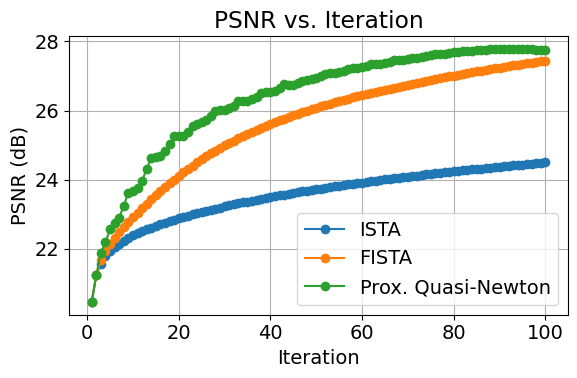

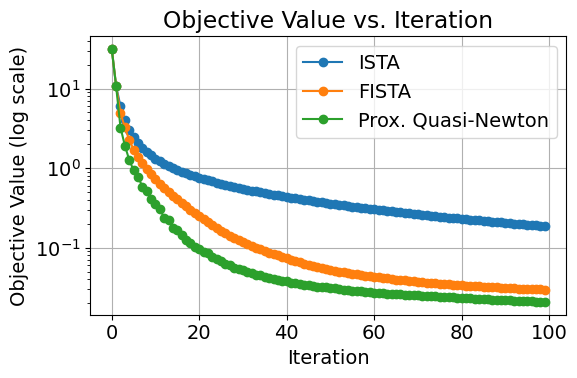

In [37]:
# -- PSNR Plot -- #
# Plot PSNR (Peak Signal-to-Noise Ratio) for each method across iterations
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(psnrs_ista2) + 1), psnrs_ista2, marker='o', label='ISTA')
plt.plot(range(1, len(psnrs_fista2) + 1), psnrs_fista2, marker='o', label='FISTA')
plt.plot(range(1, len(psnrs_quasi_newt2) + 1), psnrs_quasi_newt2, marker='o', label='Prox. Quasi-Newton')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Iteration")
plt.grid(True)
plt.tight_layout()
plt.show()

# -- Objective Value Gap Plot -- #
# Plot the objective value gap (log scale) for each method across iterations
plt.figure(figsize=(6, 4))
plt.plot(obj_vals_ista2, marker='o', label='ISTA')
plt.plot(obj_vals_fista2, marker='o', label='FISTA')
plt.plot(obj_vals_quasi_newt2, marker='o', label='Prox. Quasi-Newton')
plt.yscale('log')  # Use logarithmic scale for the objective value gap
plt.xlabel('Iteration')
plt.ylabel('Objective Value (log scale)')
plt.title('Objective Value vs. Iteration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()